#### Alex Masciotra
#### 260746829

In [1]:
# Part 2: Image Stitching

#2.1 Coding Questions



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


#1 Sift Keypoints

#Load images
img_hill1 = "./stitching_images/1Hill.JPG"
img_hill2 = "./stitching_images/2Hill.JPG"
img_hill3 = "./stitching_images/3Hill.JPG"

hill1 = cv2.imread(img_hill1)
hill2 = cv2.imread(img_hill2)
hill3 = cv2.imread(img_hill3)

#create copies of images for later
hill1_copy = hill1.copy()
hill2_copy = hill2.copy()
hill3_copy = hill3.copy()

#convert all to RGB
hill1 = cv2.cvtColor(hill1, cv2.COLOR_BGR2RGB)
hill2 = cv2.cvtColor(hill2, cv2.COLOR_BGR2RGB)
hill3 = cv2.cvtColor(hill3, cv2.COLOR_BGR2RGB)


# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

#get sift features for 1hill and 2hill
keypoints1, descriptors1 = sift.detectAndCompute(hill1, None)
keypoints2, descriptors2 = sift.detectAndCompute(hill2, None)

#draw keypoints where we display copied image
cv2.drawKeypoints(hill1, keypoints1, hill1_copy, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill2, keypoints2, hill2_copy, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)




# display
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(hill1)
plt.title("Input Image 1hill"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(hill2)
plt.title("Input Image 2hill"), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(hill1_copy)
plt.title("SIFT Features 1hill"), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(hill2_copy)
plt.title("SIFT Features 2hill"), plt.xticks([]), plt.yticks([])

plt.show()








# plot a couple of 1x128 SIFT descriptors
num = 3

for i in range(num):
    # plot the 256x1 np array using matplotlib plot()
    plt.plot(descriptors1[i])
    plt.title("Sample SIFT Descriptors 1hill")
    plt.xlim([0,128]) # set x-axis limit
plt.show()
print("Number of keypoints for 1hill: " + str(len(keypoints1)))


for i in range(num):
    # plot the 256x1 np array using matplotlib plot()
    plt.plot(descriptors2[i])
    plt.title("Sample SIFT Descriptors 2hill")
    plt.xlim([0,128]) # set x-axis limit
plt.show()
print("Number of keypoints for 2hill: " + str(len(keypoints2)))

    

    




<Figure size 1000x1000 with 4 Axes>

<Figure size 640x480 with 1 Axes>

Number of keypoints for 1hill: 1254


<Figure size 640x480 with 1 Axes>

Number of keypoints for 2hill: 1472


(Text(0.5, 1.0, 'Matched keypoints'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

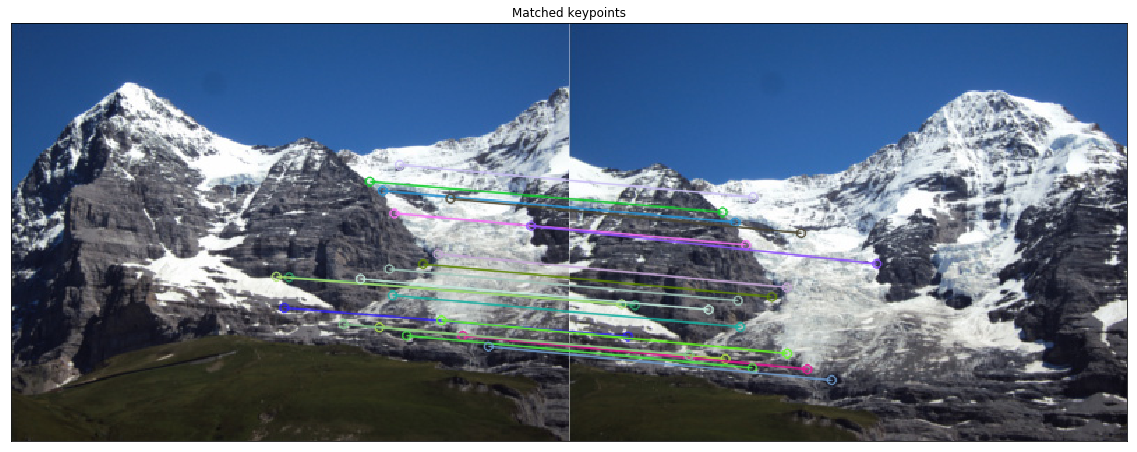

In [3]:
#Match keypoints in both images 20 best

# create BFMatcher object (bruteforce matcher using default arguments
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors1,descriptors2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw best 20 matches since they are sorted from above
matchedimg = cv2.drawMatches(hill1,keypoints1,hill2,keypoints2,matches[:20],hill1, flags=2)


plt.figure(figsize=(20,20))
plt.imshow(matchedimg)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])





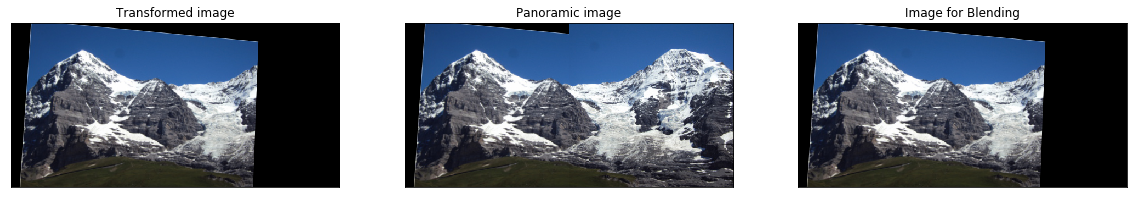

In [4]:
#Find homography using RANSAC
#need to iterate through the keypoints to create 2 separate lists for left and right matches(x1,y1, x2,y2)

GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))
    
mpr = np.float32([keypoints2[i].pt for (i,__) in GoodMatches])
mpl = np.float32([keypoints1[i].pt for (__,i) in GoodMatches])

#need to move the points in right image over.
for i in range(len(mpr)):
    mpr[i][0] = mpr[i][0]+(round(hill2.shape[1]/2)) 
#     mpr[i][0] = mpr[i][0]+(hill2.shape[1]) 


# need to use homography with ransac (line of best fit argument)
H, status = cv2.findHomography(mpl, mpr, cv2.RANSAC, 4)
warpedimg = cv2.warpPerspective(hill1, H, (hill1.shape[1]+ round(hill2.shape[1]/2),hill1.shape[0]))
#warpedimg = cv2.warpPerspective(hill1, H, (hill1.shape[1] + hill1.shape[1], hill1.shape[0]))



#warpedimg = warpedimg[:,15:warpedimg.shape[1],:] #crop some black
imgTrans = warpedimg.copy() #to display
#imgTrans = imgTrans[:, 200:655,:] #cropping out black
#warpedimg[:, hill1.shape[1]:, :] = hill2 #just to show panaramic without blending 

#need to pad hill 2 so for stitching can take half the image
hill2_blacked = np.zeros((warpedimg.shape[0], warpedimg.shape[1], warpedimg.shape[2]),np.uint8)

#now add hill2 to this image, making the same size as warped
hill2_blacked[:, warpedimg.shape[1] - hill2.shape[1]:,:] = hill2




#here move hill2 to the right side so images are properly transformed toger
#warpedimg[:,hill1.shape[1]:,:] = hill2
#zooming in to get rid of extra black on left side
#warpedimg = warpedimg[:, 200:]
#imgA = imgTrans[:,0:imgTrans.shape[1]-hill2.shape[1],:] #cropping image for blending
#imgA = imgTrans
#imgA = imgA[:,200:]#cutting out black
#imgB = warpedimg.copy() #for pyramid blending later
imgA = imgTrans
imgB = hill2_blacked

#now display unblended stitched image, taking half of each image
warpedimg[:,round(warpedimg.shape[1]/2):,:] = hill2_blacked[:,round(warpedimg.shape[1]/2):,:]


#plot results

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(imgTrans)
plt.title("Transformed image"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(warpedimg)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(imgA)
plt.title("Image for Blending"), plt.xticks([]), plt.yticks([])


plt.show()


(300, 600, 3)
(300, 600, 3)
540000
540000


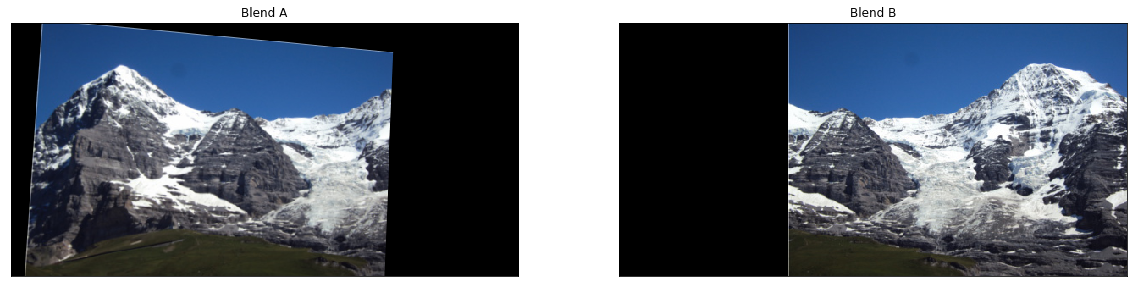

In [5]:
#4. pyramid blending



# parameters
g_size = 255  #blurr size
depth = 2  # pyramid depth size

row, col, dpt = imgA.shape
print(imgA.shape)
print(imgB.shape)
print(imgA.size)
print(imgB.size)
#rowB, columnB, dptB = imgB.shape


plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(imgA)
plt.title("Blend A"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(imgB)
plt.title("Blend B"), plt.xticks([]), plt.yticks([])
plt.show()

(300, 600, 3)
(300, 600, 3)


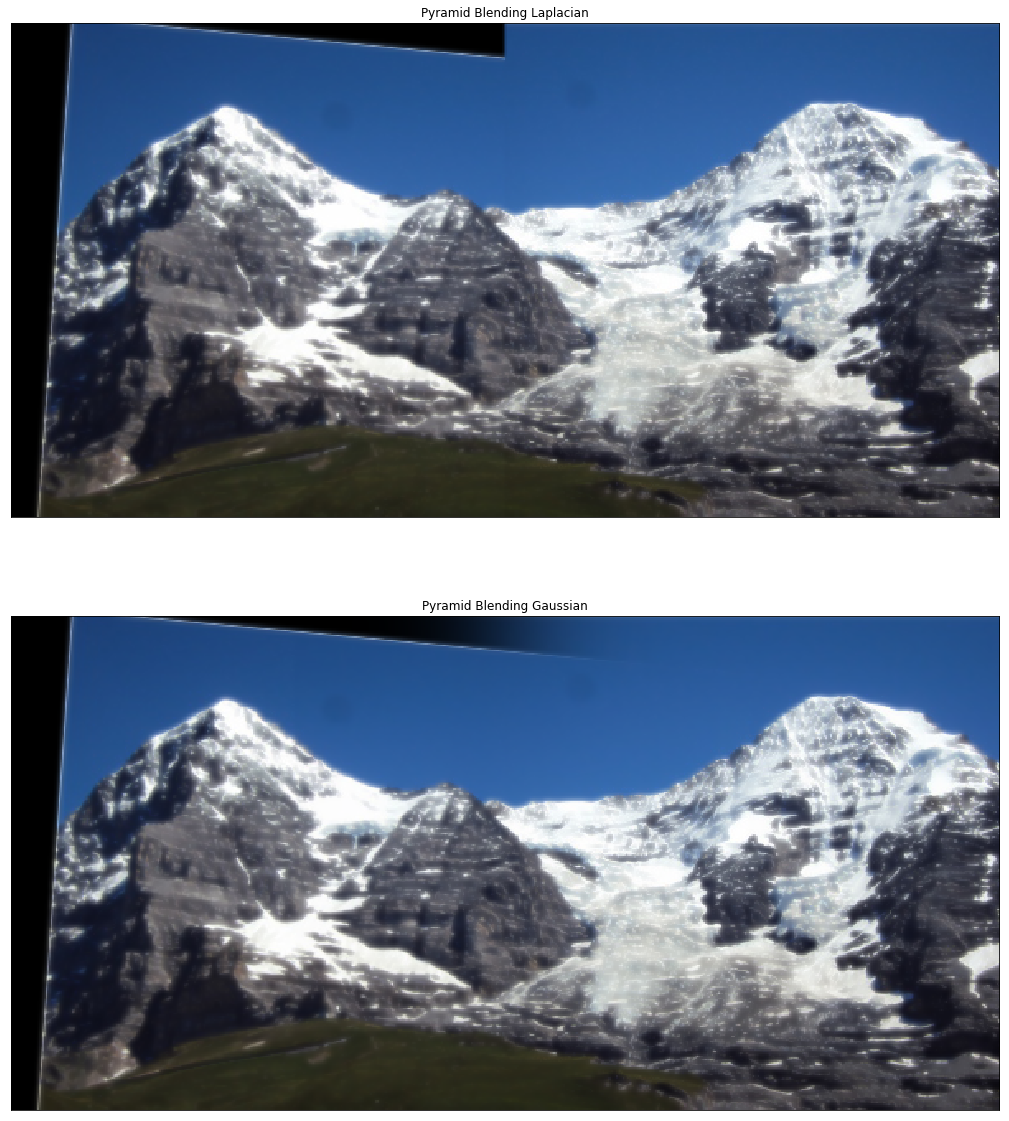

In [6]:

""" PYRAMID BLENDING """

# generate Gaussian pyramid for imgA
G = imgA.copy()
print(imgA.shape)
print(imgB.shape)
gp1 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)

# generate Gaussian pyramid for imgB
G = imgB.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

#add left and right halves of images in each level
LP = []
for la, lb in zip(lp1, lp2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb[:, round(cols/2):]))
    LP.append(lp)

# build Gaussian pyramid from selected region
mask = np.zeros((imgA.shape[0], imgA.shape[1]))
# create mask
mask[:, round(imgA.shape[1]/2):] = 1
# blur mask
mask = cv2.GaussianBlur(mask, (g_size, g_size), 0)
# generate Gaussian pyramid
G = mask.copy()
GR = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    GR.append(G)

# add left and right halves of images in each level using Gaussian mask
LP_mask = []
i = 1
for la, lb in zip(lp1, lp2):
    idx = depth - i

    # Now blend
    lp = (1-GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1)) * la + \
         GR[idx].reshape(GR[idx].shape[0],GR[idx].shape[1],1) * lb
    lp = np.uint8(lp)  # convert back to uint8
    LP_mask.append(lp)
    i += 1

# # now reconstruct
rs = LP[0]
for i in range(1, depth):
    rs = cv2.pyrUp(rs)  # upsample current lp image
    rs = cv2.add(rs, LP[i])  # add lp image

# now Gaussian mask reconstruct
rs_mask = LP_mask[0]
for i in range(1, depth):
    rs_mask = cv2.pyrUp(rs_mask)  # upsample current lp image
    rs_mask = cv2.add(rs_mask, LP_mask[i])  # add lp image

# display results
plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(rs)
plt.title('Pyramid Blending Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(rs_mask)
plt.title('Pyramid Blending Gaussian'), plt.xticks([]), plt.yticks([])
plt.show()

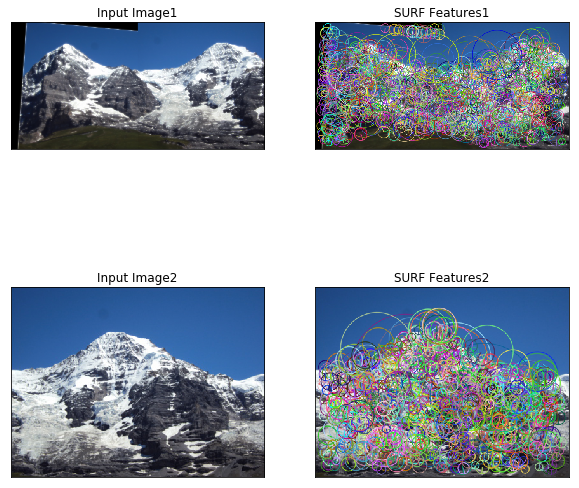

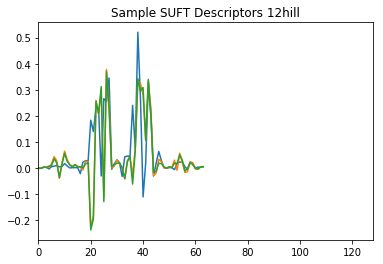

Number of keypoints for 12hill: 1302


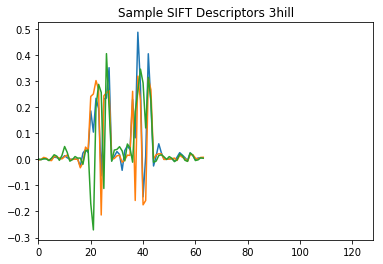

Number of keypoints for 3hill: 875


In [7]:
#create copy of image blending going to use Laplacian output because it has better defined edges
hill12 = rs.copy()



hill12_disp = hill12.copy()
hill3_disp = hill3.copy()



#convert images to grayscale

hill12_gray = cv2.cvtColor(hill12, cv2.COLOR_BGR2GRAY)
hill3_gray = cv2.cvtColor(hill3, cv2.COLOR_BGR2GRAY)

##finding surf features of 12hill and 3hill

# create SURF object

surf = cv2.xfeatures2d.SURF_create()

# detect SURF features
keypoints1_surf, descriptors1_surf = surf.detectAndCompute(hill12_gray, None)
keypoints2_surf, descriptors2_surf = surf.detectAndCompute(hill3_gray, None)

# draw keypoints
cv2.drawKeypoints(hill12, keypoints1_surf, hill12_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(hill3, keypoints2_surf, hill3_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# display images
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(hill12)
plt.title("Input Image1"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(hill12_disp)
plt.title("SURF Features1"), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(hill3)
plt.title("Input Image2"), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(hill3_disp)
plt.title("SURF Features2"), plt.xticks([]), plt.yticks([])
plt.show()

# number of SURF keypoints
for i in range(num):
    # plot the 256x1 np array using matplotlib plot()
    plt.plot(descriptors1_surf[i])
    plt.title("Sample SUFT Descriptors 12hill")
    plt.xlim([0,128]) # set x-axis limit
plt.show()
print("Number of keypoints for 12hill: " + str(len(keypoints1_surf)))

    

for i in range(num):
    # plot the 256x1 np array using matplotlib plot()
    plt.plot(descriptors2_surf[i])
    plt.title("Sample SIFT Descriptors 3hill")
    plt.xlim([0,128]) # set x-axis limit
plt.show()
print("Number of keypoints for 3hill: " + str(len(keypoints2_surf)))

    


(Text(0.5, 1.0, 'Matched keypoints'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

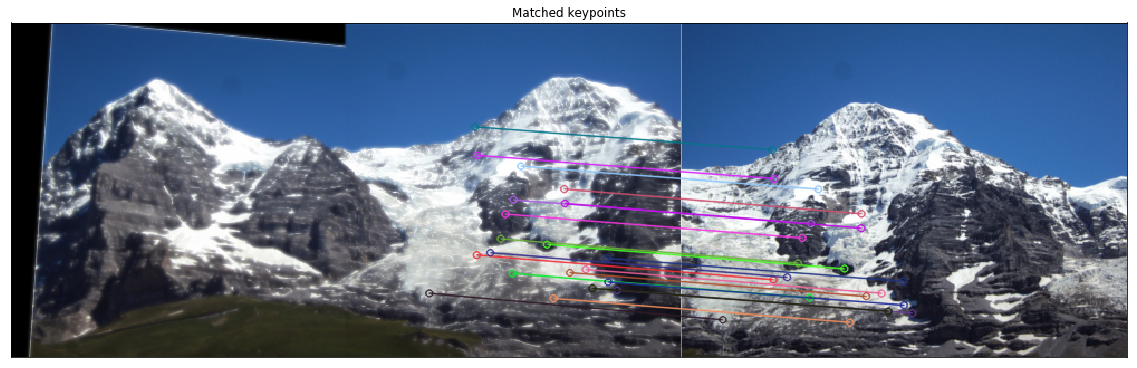

In [8]:
#find matching keypoints and display best 20

#copying code from above with existing BF matcher


# Match descriptors.
matches_surf = bf.match(descriptors1_surf,descriptors2_surf)

# Sort them in the order of their distance.
matches_surf = sorted(matches_surf, key = lambda x:x.distance)

# Draw best 20 matches since they are sorted from above
matchedimg_surf = cv2.drawMatches(hill12,keypoints1_surf,hill3,keypoints2_surf,matches_surf[:20],hill12, flags=2)


plt.figure(figsize=(20,20))
plt.imshow(matchedimg_surf)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])



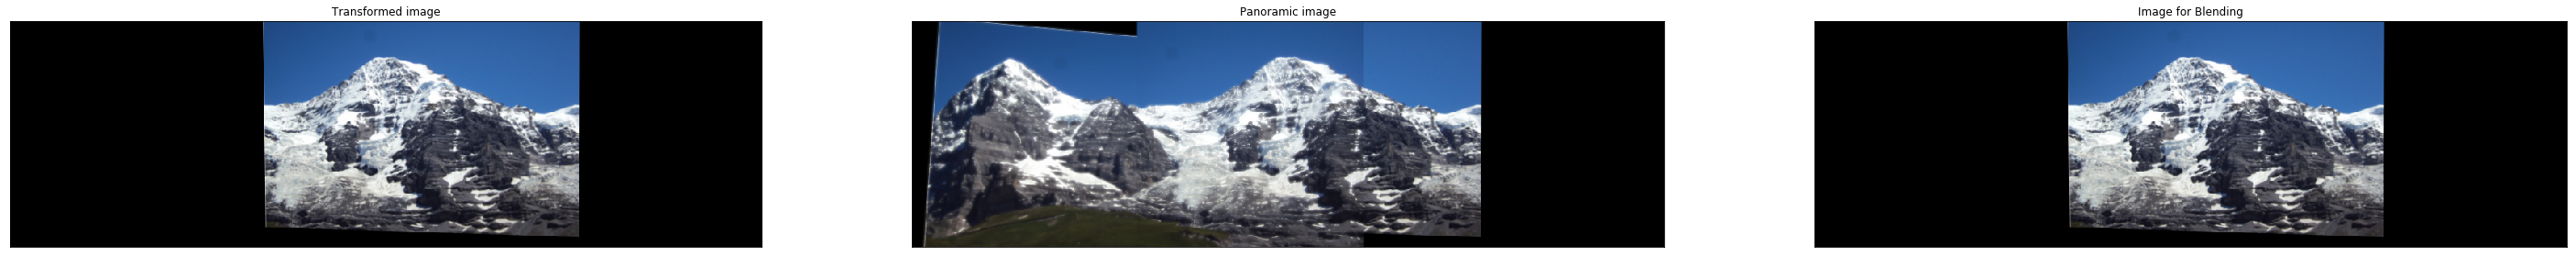

In [9]:
#3, surf:
#find homography using ransac repeat same steps as above, transform 12, fit 12 on one side as ImgA, and fit hill3 on other side





GoodMatches_surf = []
for i, m in enumerate(matches_surf):
    GoodMatches_surf.append((m.trainIdx, m.queryIdx))
    
mphill3 = np.float32([keypoints2_surf[i].pt for (i,__) in GoodMatches_surf])
mphill12 = np.float32([keypoints1_surf[i].pt for (__,i) in GoodMatches_surf])


# need to use homography with ransac (line of best fit argument)
H_surf, status = cv2.findHomography(mphill3, mphill12, cv2.RANSAC, 4)
warpedimg3 = cv2.warpPerspective(hill3, H_surf, (hill12.shape[1] + hill3.shape[1], hill1.shape[0]))

imgTrans3 = warpedimg3.copy() #to display


#need to pad hill12 on the right side so for stitching can take half the image
hill12_blacked = np.zeros((warpedimg3.shape[0], warpedimg3.shape[1], warpedimg3.shape[2]),np.uint8)

# #now add hill3 to this image, making the same size as warpedimg3
hill12_blacked[:, :warpedimg3.shape[1] - hill3.shape[1],:] = hill12




#here move hill2 to the right side so images are properly transformed toger
#warpedimg[:,hill1.shape[1]:,:] = hill2
#zooming in to get rid of extra black on left side
#warpedimg = warpedimg[:, 200:]
#imgA = imgTrans[:,0:imgTrans.shape[1]-hill2.shape[1],:] #cropping image for blending
#imgA = imgTrans
#imgA = imgA[:,200:]#cutting out black
#imgB = warpedimg.copy() #for pyramid blending later
imgB_surf = imgTrans3
imgA_surf = hill12_blacked

#create unblended stitch
#warpedimg[:,round(warpedimg.shape[1]/2):,:] = hill2_blacked[:,round(hill2_blacked.shape[1]/2):,:]
warpedimg3[:,:hill12.shape[1],:] = hill12[:, :hill12.shape[1],:]

#now display unblended stitched image, taking half of each image

#plot results

plt.figure(figsize=(50,50))
plt.subplot(131)
plt.imshow(imgTrans3)
plt.title("Transformed image"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(warpedimg3)
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(imgB_surf)
plt.title("Image for Blending"), plt.xticks([]), plt.yticks([])


plt.show()


(300, 1000, 3)
(300, 1000, 3)
900000
900000


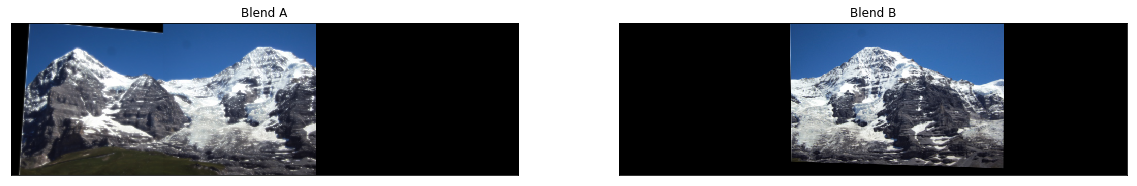

In [10]:

col, row = imgA_surf.shape[0:2]
# image with direct connecting each half
print(imgA_surf.shape)
print(imgB_surf.shape)
print(imgA_surf.size)
print(imgB_surf.size)
#rowB, columnB, dptB = imgB.shape


plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(imgA_surf)
plt.title("Blend A"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(imgB_surf)
plt.title("Blend B"), plt.xticks([]), plt.yticks([])
plt.show()

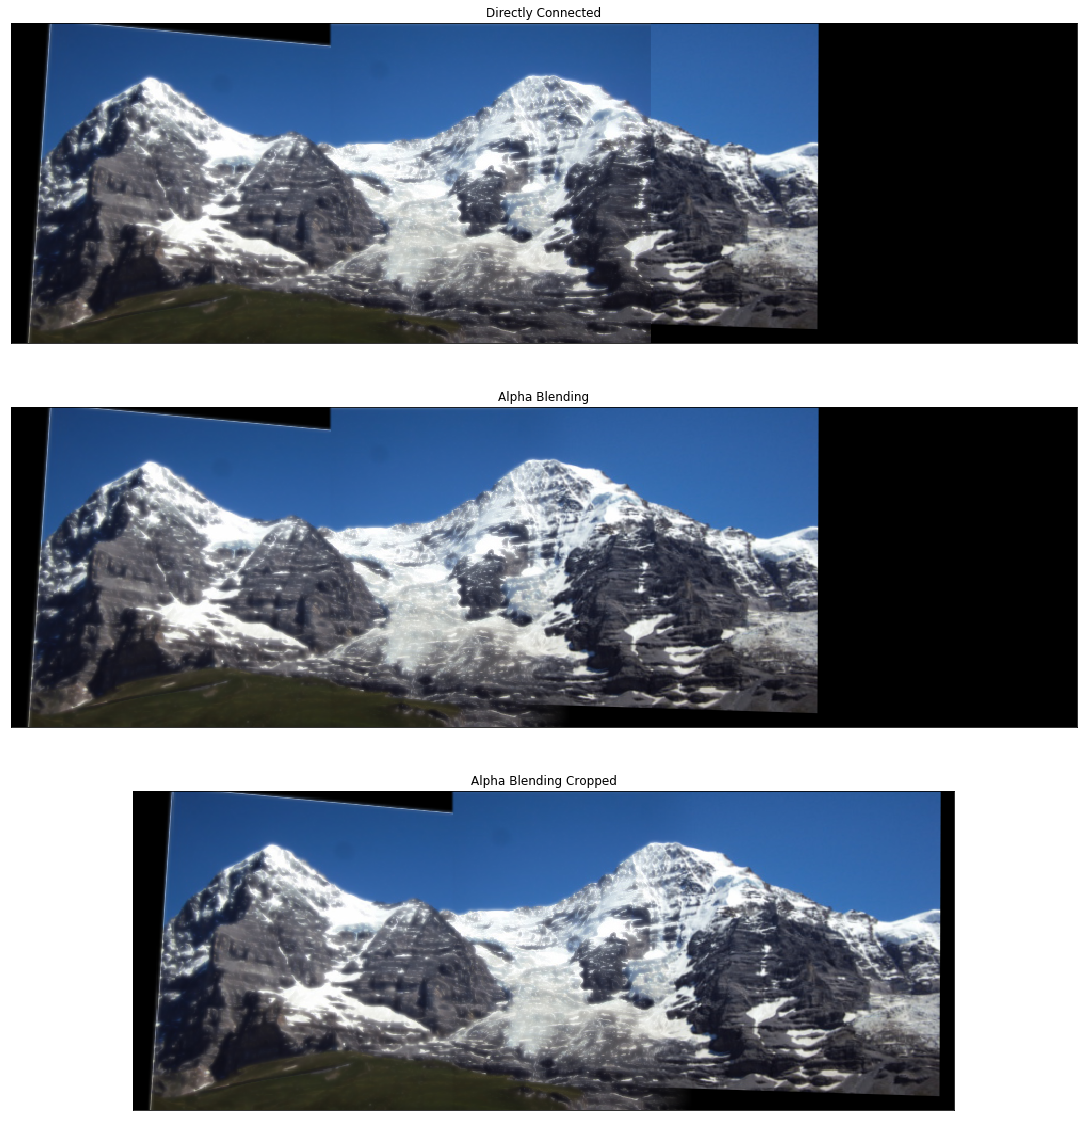

In [11]:



""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(imgA_surf.shape[1], ramp_size, round(imgA_surf.shape[1]/2), 0, 1)

# Now blend
I_blend = (1-alpha.reshape(1,-1,1)) * imgA_surf + alpha.reshape(1,-1,1)*imgB_surf
I_blend = np.uint8(I_blend)  # convert back to uint8
I_blendcropped = I_blend.copy()
I_blendcropped = I_blendcropped[:,0:770,:]

# display images
plt.figure(figsize=(20,20))
plt.subplot(311), plt.imshow(warpedimg3)
plt.title("Directly Connected"), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(I_blend)
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(I_blendcropped)
plt.title("Alpha Blending Cropped"), plt.xticks([]), plt.yticks([])
plt.show()

# 2.2 Reasoning Questions

#####  1. 



Both Sift and SURF are composed of 2 parts, feature detection and description. In SIFT the detector uses a DoG (difference of gaussian) which detects interest poitns on blob like features. SURF as it says in its name, (speeded up robust features) is was designed to operate 3-6 times faster than Sift. This can be attributed to the fact that Sift uses the Harris Approach and Hessian matrix to detect keypoints while SURF uses the Fast Hessian, which is the determinant of the hessian matrix to compute keypoints. As Surf is faster, it is not as Robust as Sift. From this assignment, keypoints were computed by using both sift and surf features. Sift returned more keypoints than Surf. This can be seen above. 




##### 2.

A pro for Linear Blending is that it is easy to implement and code. A downside of this is that it is not always possible to get a great result because when you alpha blend, you take the weighted average of every pixed which is dependent on its distance from the map. Another con is that the blending needs to occur at low frequencies in order for smooth but clear transitions to occur and is deeply dependent on its window size. Linear blending is good to use when theres a big area around the same color like the mountain and sky that was used in this assignment. This is because all the colors are similar and taking the weighted average creates a nice blend. 

Pyramid blending breaks down the image into several levels, by way of either a Gaussian or Laplacian pyramid. This type of blending is superior to linear blending and produces more consistent results. It also performs well at all frequencies both low and high. The main con to pyramid blending is that it is hard to implement and takes alot of memory. 

It is better to use pyramid blending over linear blending when operating at high frequencies. 



##### 3. 

A random subset of pairs of matching keypoints means that there will be goodmatches and badmatches used to find homography. This will create a bad result when finding homography. The image will be misaligned and kind of useless to compute and the Homography matrix wont be of any use. This can be attributed to the mix of good and badmatches 



##### 4 
The relationship between the number of matching key points and accuracy of homography can be described by a Gaussian distribution. A subset of quality matching keypoints will yield the best homography. Too little or too many keypoints will cause the homography to be subpar. This is because with less keypoints there is not enough data to compute an accurate homography. However, too many keypoints would be too much data to satisfy to create an accurate homography. It is more important to have quality keypoints vs quantity keypoints to have an accurate result
